$$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 20165549\ \ JANG\ \ JAE\ \ YONG$$

Build a binary classifier based on 3 layers neural network using the human versus horse dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import pandas as pd

transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),
    # the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100]
    # (notice : [channel, height, width] )
                                transforms.ToTensor(),])

#train_data_path = 'relative path of training data set'
train_data_path = 'horse-or-human/horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)  

validation_data_path = 'horse-or-human/horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=1)  

NUM_EPOCH = range(1) # my code

#
# Image size and number of data
#
image_size = 10000
train_count = 1027
validation_count = 256

train_label = np.empty(train_count, dtype=float)
train_data = np.ones((train_count, image_size), dtype=float)

validation_label = np.empty(validation_count, dtype=float)
validation_data = np.ones((validation_count, image_size), dtype=float)

for epoch in (NUM_EPOCH):
    # load training images of the batch size for every iteration
    for i, data in enumerate(trainloader):

        # inputs is the image
        # labels is the class of the image
        inputs, labels = data

        # if you don't change the image size, it will be [batch_size, 1, 100, 100]
        #print(inputs.shape)

        # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
        #print(labels)
        
        train_label[i] = int(labels)
        train_tmp = np.asfarray(inputs)
        train_data[i, :] = train_tmp[0, 0, :, :].reshape(10000)
        
    # load validation images of the batch size for every iteration
    for i, data in enumerate(valloader):
        
        # inputs is the image
        # labels is the class of the image
        inputs, labels = data

        # if you don't change the image size, it will be [batch_size, 1, 100, 100]
        #print(inputs.shape)

        # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
        #print(labels)
        
        validation_label[i] = int(labels)
        validation_tmp = np.asfarray(inputs)
        validation_data[i, :] = validation_tmp[0, 0, :, :].reshape(10000)

In [167]:
delta = 10**(-9)
iteration = 10000 # Max Iteration

tr_label = train_label.reshape(train_count, 1)
va_label = validation_label.reshape(validation_count, 1)
loss_arr = np.zeros(iteration, dtype=float)
t_loss_arr = np.zeros(iteration, dtype=float)
loss_value_arr = np.zeros(iteration, dtype=float)
t_loss_value_arr = np.zeros(iteration, dtype=float)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def loss_function(t, y):
    return -np.mean(t*np.log(y+delta) + (1-t)*np.log(1-y+delta)) 

In [158]:
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x) + delta)

def ReLU(x):
    return np.maximum(0, x)

def LeakyReLU(x):
    return np.maximum(0.1*x, x)

In [159]:
def ActivationFunc(FunctionName, x):
    
    if FunctionName == 'sigmoid':
        return sigmoid(x)
    elif FunctionName == 'tanh':
        return tanh(x)
    elif FunctionName == 'ReLU':
        return ReLU(x)
    elif FunctionName == 'LeakyReLU':
        return LeakyReLU(x)

In [160]:
def d_ActivationFunc(FunctionName, x):
    
    if FunctionName == 'sigmoid':
        return sigmoid(x) * (1 - sigmoid(x))
    elif FunctionName == 'tanh':
        return 1 - (tanh(x))**2
    elif FunctionName == 'ReLU':
        return 1. * (x > 0)
    elif FunctionName == 'LeakyReLU':
        return 1. * (x > 0) + 0.1 * (x < 0)

In [165]:
def ThreeLayerNeuralNetwork(FuncName, lambda_):
    
    learningRate = 8 * 10**(-4) # learningRate
    prev_loss = 0
    
    uc = 50   # u
    vc = 5   # v
    wc = 1   # w
    
    a = np.ones((train_count, uc), dtype=float)
    b = np.ones((train_count, vc), dtype=float)
    c = np.ones((train_count, wc), dtype=float)
    h = np.ones((train_count, wc), dtype=float)
    
    t_a = np.ones((validation_count, uc), dtype=float)
    t_b = np.ones((validation_count, vc), dtype=float)
    t_c = np.ones((validation_count, wc), dtype=float)
    t_h = np.ones((validation_count, wc), dtype=float)

    u = np.random.randn(image_size, uc) #/ np.sqrt(image_size)
    v = np.random.randn(uc, vc) #/ np.sqrt(uc)
    w = np.random.randn(vc, wc) #/ np.sqrt(vc)
    
    b1 = np.random.rand(uc)
    b2 = np.random.rand(vc)
    b3 = np.random.rand(wc)
    
    b1 *= 0.1
    b2 *= 0.1
    b3 *= 0.1
    
    d_lc = np.empty(train_count, dtype=float)
   
    for iter in range(iteration): # Max Iteration = 10000
        
        #
        # training matrix
        
        a = (train_data).dot(u) + b1
        b = (ActivationFunc(FuncName, a)).dot(v) + b2
        c = (ActivationFunc(FuncName, b)).dot(w) + b3
        h = sigmoid(c)

        #
        # validation matrix for loss value calculation
        t_a = (validation_data).dot(u) + b1
        t_b = (ActivationFunc(FuncName, t_a)).dot(v) + b2
        t_c = (ActivationFunc(FuncName, t_b)).dot(w) + b3
        t_h = sigmoid(t_c)

        loss_value = loss_function(tr_label, h) + (1/2)*(lambda_)*(np.sum(u**2) + np.sum(v**2) + np.sum(w**2))
        t_loss_value = loss_function(va_label, t_h) + (1/2)*(lambda_)*(np.sum(u**2) + np.sum(v**2) + np.sum(w**2))
        training_loss = np.sum(np.abs(tr_label- h) > 0.5)
        testing_loss = np.sum(np.abs(va_label- t_h) > 0.5)
        
        loss_value_arr[iter] = loss_value
        t_loss_value_arr[iter] = t_loss_value
        loss_arr[iter] = training_loss
        t_loss_arr[iter] = testing_loss
        
        ## derivation
        d_lc = h - tr_label
        loss3 = d_lc * d_ActivationFunc(FuncName, c)
        loss2 = loss3.dot(w.T) * d_ActivationFunc(FuncName, b)
        loss1 = loss2.dot(v.T) * d_ActivationFunc(FuncName, a)

        w = (1 - learningRate*lambda_) * w - learningRate * ((ActivationFunc(FuncName, b)).T).dot(loss3)
        b3 = b3 - learningRate * np.mean(loss3, axis=0)
        v = (1 - learningRate*lambda_) * v - learningRate * ((ActivationFunc(FuncName, a)).T).dot(loss2)
        b2 = b2 - learningRate * np.mean(loss2, axis=0)
        u = (1 - learningRate*lambda_) * u - learningRate * ((ActivationFunc(FuncName, train_data)).T).dot(loss1)
        b1 = b1 - learningRate * np.mean(loss1, axis=0)
                
        if round(loss_value, 6) == round(prev_loss, 6): # Terminate to Iteration
            break
        
        prev_loss = loss_value
    
    LossPlot(FuncName, iter + 1)
    AccuracyPlot(FuncName, iter + 1)
    Loss_And_Accuracy_Table(FuncName, iter + 1)
    
    return

In [153]:
def LossPlot(FuncName, iteration):
    x = range(iteration)
    y1 = loss_value_arr[x]
    y2 = t_loss_value_arr[x]

    plt.plot(x, y1, color='b', label='$Train$')
    plt.plot(x, y2, color='r', label='$Validation$')
    plt.legend(loc="upper right")
    plt.title(FuncName + ' Training and Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

In [154]:
def AccuracyPlot(FuncName, iteration):
    x = range(1, iteration)
    y1 = (train_count - loss_arr[x]) / train_count
    y2 = (validation_count - t_loss_arr[x]) / validation_count

    plt.plot(x, y1, color='b', label='$Train$')
    plt.plot(x, y2, color='r', label='$Validation$')
    plt.legend(loc="upper left")
    plt.title(FuncName + ' Training and Validation Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy percent')
    plt.show()

In [155]:
def Loss_And_Accuracy_Table(FuncName, iteration):
    #print(FuncName + ' Loss and Accuracy Table')
    print()
    idx1 = round(loss_value_arr[iteration - 1], 6)
    idx2 = str(round((train_count - loss_arr[iteration - 1]) / train_count * 100, 10)) + ' %'
    idx3 = round(t_loss_value_arr[iteration - 1], 6)
    idx4 = str(round((validation_count - t_loss_arr[iteration - 1]) / validation_count * 100, 10)) + ' %'

    df = pd.DataFrame(data=np.array([[idx1, idx2], [idx3, idx4]]), index= ['Training', 'Validation'], columns=['Loss', 'Accuracy'])
    display(df)

$Variance\ (large\ \lambda)\ \ \ \ \lambda=10^{-2}\ ({\lambda \over n})$

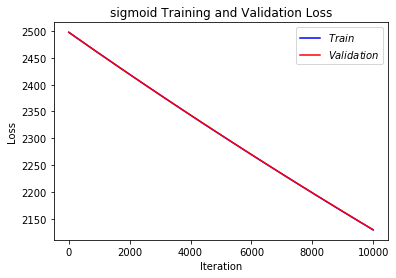

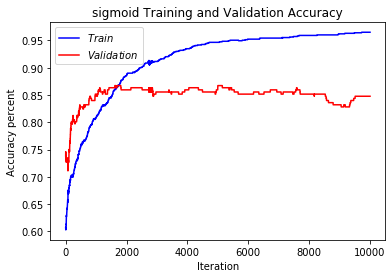

,Loss,Accuracy
Training,2129.047279,96.4946445959 %
Validation,2129.323501,84.765625 %


In [170]:
np.random.seed(3)
_lambda = 10**(-2)
ThreeLayerNeuralNetwork('sigmoid', _lambda)

MarkDown :

| Dataset | Loss | Accuracy |
|:--------|:--------:|--------:|
| Training | 0.444191 | 96.4946445959% |
| Validation | 0.636015 | 84.7656250000% |

$Bias\ (small\ \lambda)\ \ \ \ \lambda=10^{-5}\ ({\lambda \over n})$

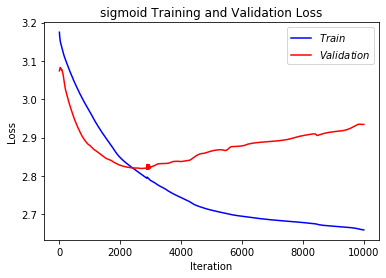

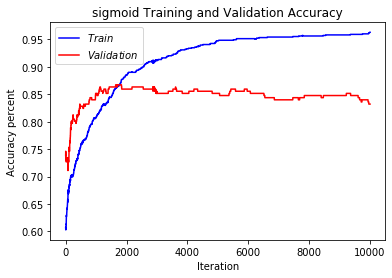

,Loss,Accuracy
Training,2.659026,96.299902629 %
Validation,2.934327,83.203125 %


In [145]:
np.random.seed(3)
_lambda = 10**(-5) # lambda
ThreeLayerNeuralNetwork('sigmoid', _lambda)

MarkDown :

| Dataset | Loss | Accuracy |
|:--------|:--------:|--------:|
| Training | 2.659026 | 96.2999026290% |
| Validation | 2.934327 | 83.2031250000% |

$Best\ Generalization\ (appropriate\ \lambda)\ \ \ \ \lambda=10^{-3}$

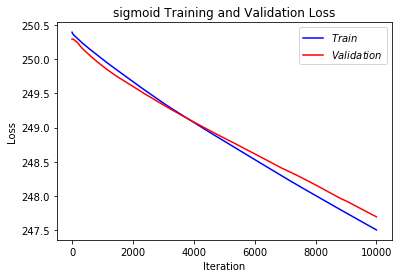

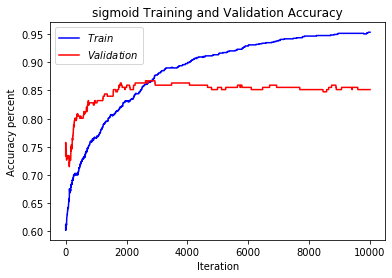

,Loss,Accuracy
Training,247.500688,95.33 %
Validation,247.692399,85.16 %


In [122]:
np.random.seed(3)
_lambda = 10**(-3) # lambda
ThreeLayerNeuralNetwork('sigmoid', _lambda)

MarkDown :

| Dataset | Loss | Accuracy |
|:--------|:--------:|--------:|
| Training | 247.500688 | 95.3300000000% |
| Validation | 247.692399 | 85.1600000000% |